# HA-LAT-001
## Latencia en evaluación de correctitud de una respuesta enviada en examen teórico

### Experimento


#### importación de librerias e inicialización de variables

In [1]:
%matplotlib widget
import grequests
import requests
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import numpy as np
import random 

#path_url = "http://localhost:8000"
path_url = "http://lb-abcjobs-exp-1-v2-1155292492.us-east-1.elb.amazonaws.com"
questions_cant = 2
answers_cant = 4 # respuestas por cada pregunta
num_requests = 5
num_async_calls = 1

#### Base de datos

In [2]:
def populate_quizes():
  requests.get(f"{path_url}/truncquizes")
  requests.get(f"{path_url}/populatequizes/{questions_cant}/{answers_cant}")
  return True 

populate_quizes()  

True

#### consumo de servicio de validación de respuesta

In [3]:
def call_service(iteration):
  global num_async_calls
  urls = []  
  #print(f"inicia petición: {num_async_calls}")  
  for q in range(num_async_calls):
    question_id = random.randint(1,questions_cant)
    max_answer_id = (answers_cant * question_id)
    min_answer_id = max_answer_id - answers_cant + 1
    answer_id = random.randint(min_answer_id,max_answer_id)
    urls.append(f"{path_url}/checkanswer/{question_id}/{answer_id}")  
  our_requests = (grequests.get(link) for link in urls)
  responses = grequests.map(our_requests)  
  #print(f"num_async_calls: {num_async_calls}")    
  #print(f"finaliza petición: {num_async_calls}")
  #num_async_calls = num_async_calls * 2
  num_async_calls = num_async_calls + iteration
  return responses

call_service(1)

[<Response [200]>]

Gráfica

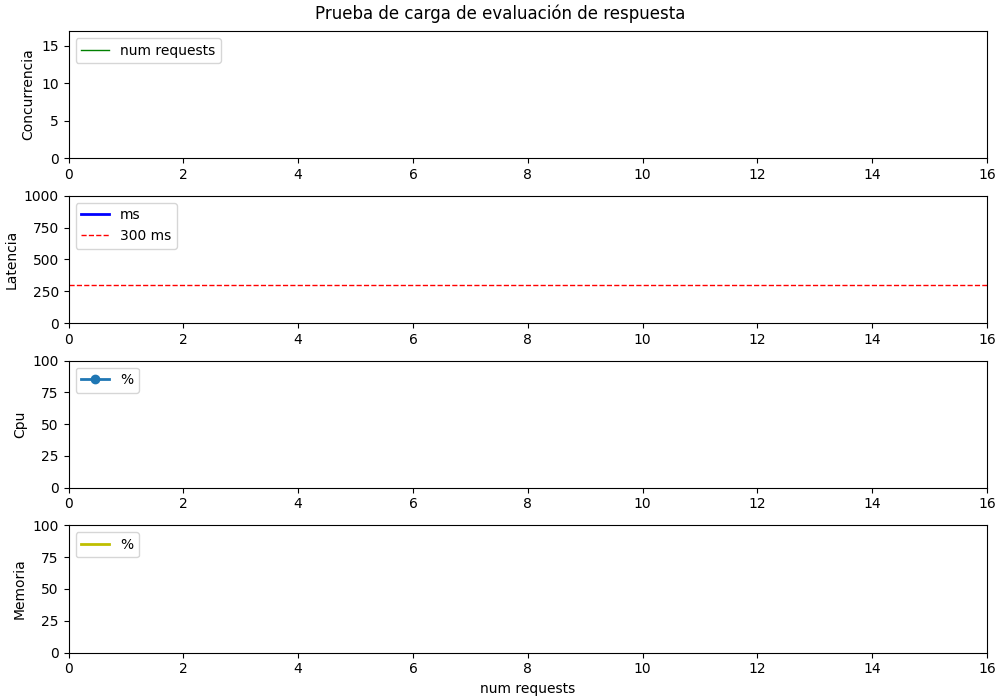

X: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
latency: [3]
cpu: [0]
memory: [22]
X: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
latency: [3 3 4]
cpu: [0 0 0]
memory: [22 22 22]
X: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
latency: [3 3 4 4 4 3 3]
cpu: [0 0 0 0 0 0 0]
memory: [22 22 22 22 22 22 22]
X: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
latency: [ 3  3  4  4  4  3  3  6  7  6  8  6 38  4]
cpu: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
memory: [22 22 22 22 22 22 22 22 22 22 22 22 22 22]
X: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
latency: [ 3  3  4  4  4  3  3  6  7  6  8  6 38  4  4  5  3 76 72 80  5  2  3 75
  3]
cpu: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
memory: [22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22]


In [10]:
concurrence_array = []
latency_array = []
cpu_array = []
memory_array = []

#num_x_data = pow(2, (num_requests))
num_x_data = sum(range(num_requests+1))
xlim = num_x_data + 1

X = np.linspace(0, num_x_data, num_x_data+1).astype(int)

def update_plot(n):
  #print(f"entra a update_plot: {n}")
  n = n - 1
  concurrence = np.array(concurrence_array).astype(int)
  latency = np.array(latency_array).astype(int)
  cpu = np.array(cpu_array).astype(int)
  memory = np.array(memory_array).astype(int)
  print(f"X: {X}")
  print(f"latency: {latency}")
  print(f"cpu: {cpu}")
  print(f"memory: {memory}")
  line[0].set_data(X[:n], concurrence[:n])
  line[1].set_data(X[:n], latency[:n])
  line[2].set_data(X[:n], cpu[:n])
  line[3].set_data(X[:n], memory[:n])
  return line

def data_gen():
  global num_async_calls, concurrence_array, latency_array, cpu_array, memory_array
  num_async_calls = 1
  concurrence_array.clear()
  latency_array.clear()
  cpu_array.clear()
  memory_array.clear()
  #print("ingresa a data_gen")
  for iteration in range(num_requests):
    #print(f"iteración gen_data: {i}")
    responses = call_service(iteration+1)
    #print(f"responses: {responses}")
    for response in responses:
      if response :
        data = response.json()
        concurrence_array.append(num_async_calls)
        latency_array.append(data["latency_ms"])
        cpu_array.append(data["cpu_perc"])
        memory_array.append(data["mem_perc"])
        #print(f"response: {response}, data: {data}")
    yield num_async_calls
 
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, constrained_layout = True, figsize=(10,7))
#fig.tight_layout()
fig.suptitle('Prueba de carga de evaluación de respuesta')

lines0, = ax0.plot([], [], 'g-', lw=1, label="num requests")
ax0.set_ylabel('Concurrencia')
ax0.set_ylim(0, num_x_data+2)
ax0.set_xlim(0, xlim)
ax0.legend(loc='upper left')

lines1, = ax1.plot([], [], 'b-', lw=2, label="ms")
ax1.set_ylabel('Latencia')
ax1.set_ylim(0, 1000)
ax1.set_xlim(0, xlim)
ax1.axhline(y=300, color="r", label="300 ms", linewidth=1, linestyle='--')
ax1.legend(loc='upper left')

lines2, = ax2.plot([], [], 'o-', lw=2, label="%")
ax2.set_ylabel('Cpu')
ax2.set_ylim(0, 100)
ax2.set_xlim(0, xlim)
ax2.legend(loc='upper left')

lines3, = ax3.plot([], [], 'y-', lw=2, label="%")
ax3.set_xlabel('num requests')
ax3.set_ylabel('Memoria')
ax3.set_ylim(0, 100)
ax3.set_xlim(0, xlim)
ax3.legend(loc='upper left')

line = [lines0, lines1, lines2, lines3]

#ani = animation.FuncAnimation(fig, update_plot, frames=8, repeat=False )
ani = animation.FuncAnimation(fig, update_plot, data_gen, interval=500, repeat=False, cache_frame_data=False)
#ani = animation.FuncAnimation(fig, update_plot, np.linspace(0, 3, 3), interval=500, repeat=False, cache_frame_data=False)
plt.show()
#plt.close()